In [1]:
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('../helper/')

import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import metrics
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import importlib

import torch

import models
import helper_functions as hpfn
from configs_cnn_space_inv import *

In [2]:
# specify the folder where the data are saved
data_folder = '/mnt/d/data/'
folder_nat = data_folder + 'panoramic/data_natural_only/'
folder_nat_filtered = data_folder + 'panoramic/data_natural_only_filtered/'



In [3]:
# get lists of hyper parameters
config = get_config()
L = config.L # width of the input array
D_cnn_list = config.D_cnn_list # list of depth
C_list = config.C_list # list of number of independent channels
k_list = config.k_list # list of kernel size
Repeat = config.Repeat # repeat for different initializations
k_folds = config.k_folds
activationf = config.activationf # activation functions, which can be 'ReLU', 'LeakyReLU' or 'ELU'.
T = config.T # length in time (one for 10 ms)
od = config.od
model_folder = config.save_folder_local
figure_folder = config.figure_folder

figure_folder = config.figure_folder
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

print(model_folder)
print(figure_folder)

/mnt/d/research/counter_evidence/cnn_space_inv_scal100/
../results/preliminary_figures_cnn_space_inv_scal100/


In [4]:
# get lists of hyper parameters
fold_list = list(range(k_folds))

# Get the tick label list
tick_label_list = []
for D_cnn in D_cnn_list:
    for C in C_list:
        tick_label_list.append(f'D{D_cnn}C{C}')
                    
# Get config dict list
config_dict_list = []
for D_cnn in D_cnn_list:
    for C in C_list:
        for k in k_list:
            config_dict_list.append({'Dcnn': D_cnn, 'C':C, 'k':k})

# Show the validation loss for the last epoch

(48, 5)


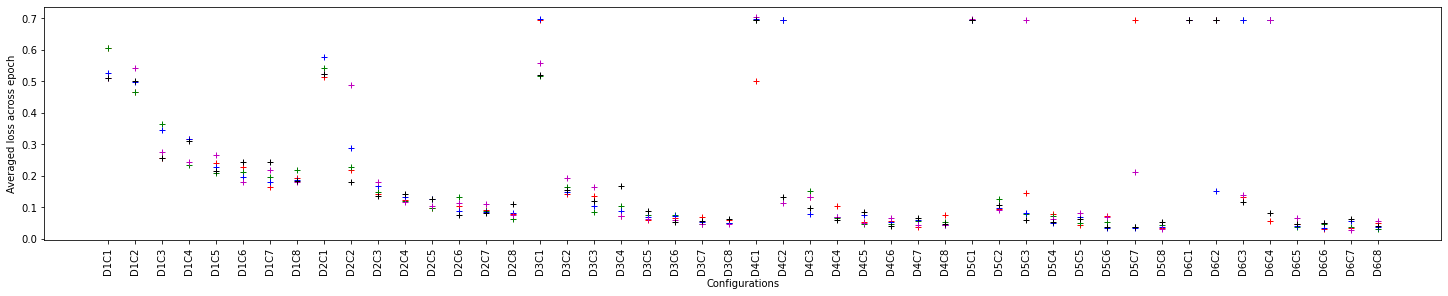

In [5]:
valid_loss_list = []
tick_label_list = []
for R in range(Repeat)[0:1]:
    for k in k_list[0:1]:
        for D_cnn in D_cnn_list:
            for C in C_list:
                valid_loss_fold_list = []
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_k{k}_' + config.activationf + f'_R{R+1}/'
                for fold in range(1, k_folds+1):
                    if os.path.exists(model_path+f'model_fold_{fold}.pth'):
                        # final validate loss
                        valid_loss = torch.load(model_path + f'valid_loss_fold_{fold}_final.pth')
                        valid_loss_fold_list.append(valid_loss)
                    else:
                        valid_loss_fold_list.append(1.)
                tick_label_list.append(f'D{D_cnn}C{C}')
                valid_loss_list.append(valid_loss_fold_list)
valid_loss_array = np.array(valid_loss_list)
print(valid_loss_array.shape)

color_fold = ['r', 'g', 'b', 'm', 'k', 'y', 'grey', 'r', 'g']

fig = plt.figure(figsize=(20, 4), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0, 0])

ind = 0
for D_cnn in D_cnn_list:
    for C in C_list:
        for fold in range(k_folds):
            valid_loss = valid_loss_array[ind][fold]
            ax.plot(ind, valid_loss, '+', c=color_fold[fold])
        ind = ind + 1
ax.set_xticks(list(range(ind)))
ax.set_xticklabels(tick_label_list, rotation=90)
ax.set_xlabel('Configurations')
ax.set_ylabel('Averaged loss across epoch')
                
plt.show()

fig.savefig(figure_folder+'valid_loss_all_models.pdf', bbox_inches='tight')


# Show the training and validating losses for all the models

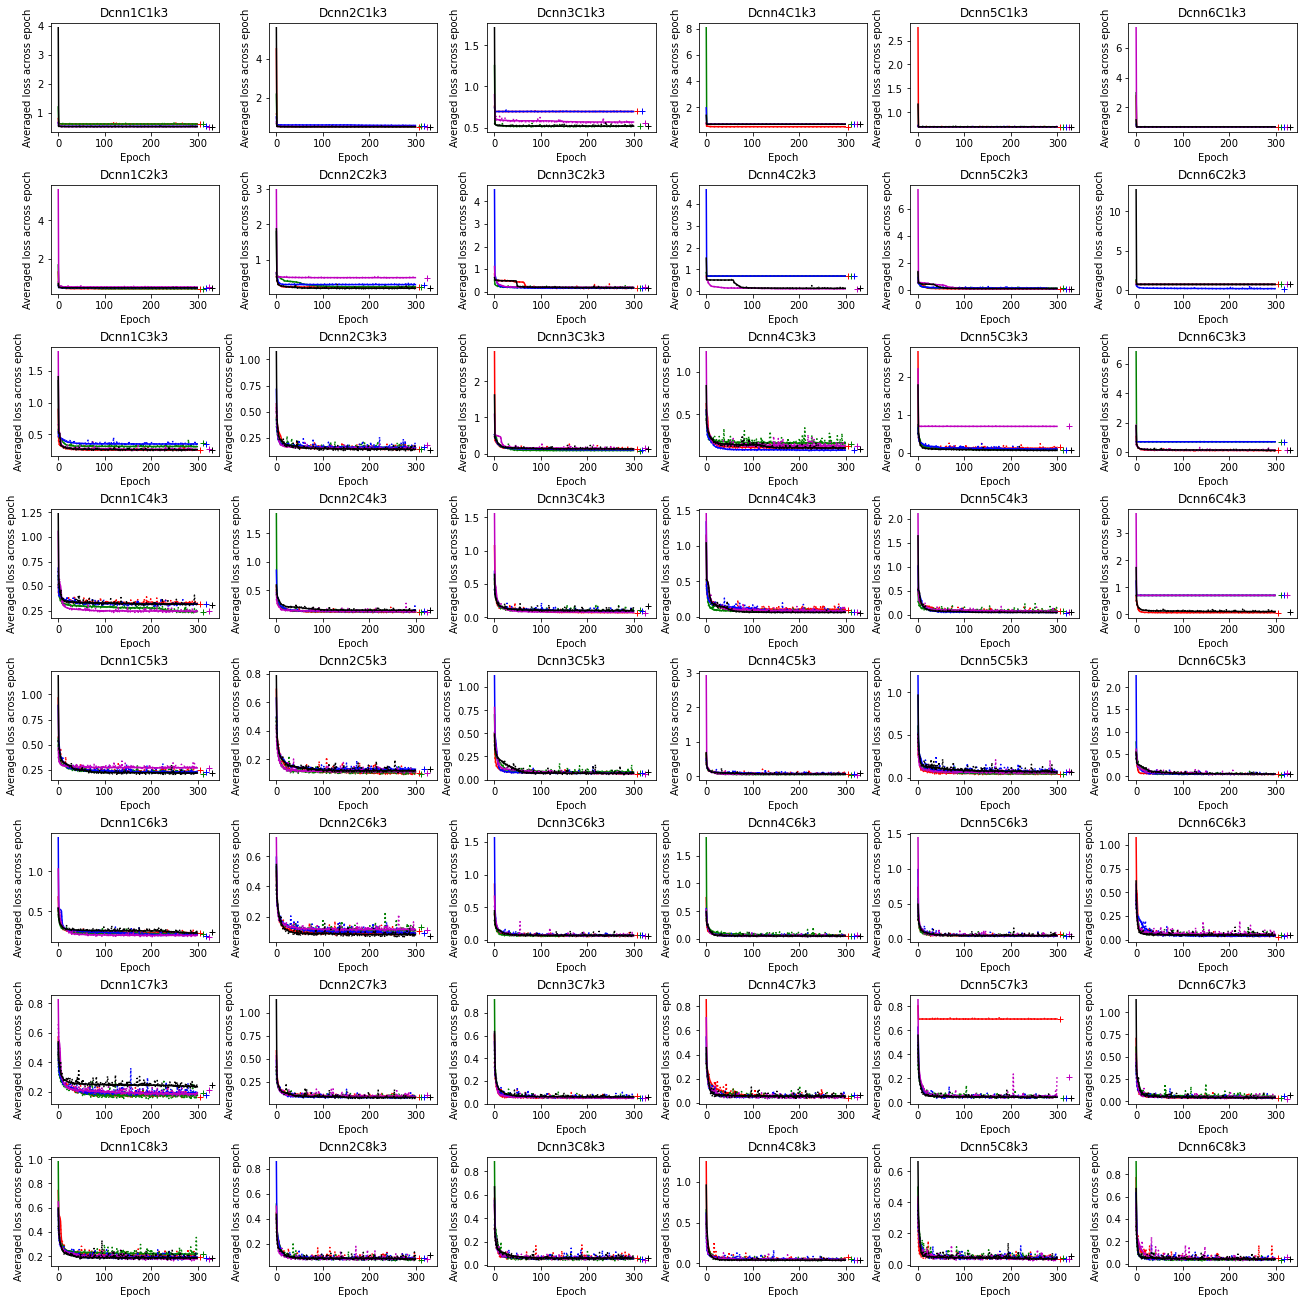

In [6]:
fig = plt.figure(figsize=(18, 18), constrained_layout=True)
gs = GridSpec(8, 6, figure=fig)


for R in range(Repeat)[0:1]:
    for k in k_list[0:1]:
        for coln, D_cnn in enumerate(D_cnn_list):
            rown = 0
            for C in C_list:
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_k{k}_' + config.activationf + f'_R{R+1}/'
                # Loss functions
                legend_list = []
                ax = fig.add_subplot(gs[rown, coln])
                for fold in range(k_folds):
                    if os.path.exists(model_path + f'train_loss_fold_{fold+1}.pth'):
                        # train loss
                        loss_path = model_path + f'train_loss_fold_{fold+1}.pth'
                        loss = torch.load(loss_path)
                        lines = ax.plot(loss, c=color_fold[fold])
                        legend_list.append(lines[0])
                        # validate loss
                        loss_path = model_path + f'valid_loss_fold_{fold+1}.pth'
                        loss = torch.load(loss_path)
                        ax.plot(loss, c=color_fold[fold], linestyle=':')
                        # final validate loss
                        valid_loss = torch.load(model_path + f'valid_loss_fold_{fold+1}_final.pth')
                        ax.plot(len(loss)*(1.+0.02*(fold+1)), valid_loss, '+', c=color_fold[fold])
                ax.set_title(f'Dcnn{D_cnn}C{C}k{k}')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Averaged loss across epoch')

                rown = rown + 1
plt.show()

fig.savefig(figure_folder+'loss_all_models.pdf', bbox_inches='tight')




# Test models on synthetic data

In [6]:
# Generate and save synthetic data
importlib.reload(hpfn)

# impose motion with foreground
delta_t = 0.01 # time resolution, in second
Ts = 50 # each step is 10 millisecond or 0.01 second
shift = 80 # in degree per second
M = 100 # number of sample stimuli
N = 20 # number of moving objects
pix_per_deg = 1
FWHM = 5 # in degree
sigma_for_gaussian = np.round(FWHM/(2*np.sqrt(2*np.log(2)))*pix_per_deg, 1) # smoothing gaussian
pad_size = int(4*sigma_for_gaussian) # this comes from the fact that the gaussian is truncated at 4*std

K = 5
w = 3

stimuli_no_foreground_all = np.zeros((M, Ts, 1, 72))
stimuli_uniform_moving_window_all = np.zeros((M, Ts, 1, 72))
stimuli_uniform_all = np.zeros((M, Ts, 1, 72))
stimuli_structured_flicker_all = np.zeros((M, Ts, 1, 72))
stimuli_structured_all = np.zeros((M, Ts, 1, 72))
stimuli_structured_moving_window_all = np.zeros((M, Ts, 1, 72))

for m in range(M):
    # Stimulus, the original frame of image with objects
    Ls = 5 + 0 * np.random.random(N) # angular spans of the objects, in degree
    X0s = 360 * np.random.random(N) # initial positions of the objects, in degree (leftmost (rightmost) edge is 0 (360).).
    img_with_objects = np.zeros((1, 360))
    image_patch = np.ones((1, 5)) # Get the image patches as the objects
    row = 0
    for n in range(N):
        x = X0s[n]
        l = Ls[n]
        img_with_objects, _ = hpfn.add_object_to_image_periodic_boundary(img_with_objects, x, l, row, image_patch, deg_x=360, deg_y=5)
    # Spacial filtering
    img_with_objects_smoothed = hpfn.get_filtered_spacial(img_with_objects, pad_size, sigma_for_gaussian)

    # get open windows
    open_windows = hpfn.get_open_windows(K, w)
    
    # no foreground
    pattern = 'none'
    _, _, img_with_objects_resized_motion, _ \
    = hpfn.get_movie_with_1d_foreground(img_with_objects_smoothed, delta_t, Ts, shift, open_windows, pattern, val=0)
    stimuli_no_foreground_all[m] = img_with_objects_resized_motion
    
    # uniform foreground but with moving windows
    pattern = 'uniform'
    moving_window = True
    _, img_with_objects_resized_motion_with_foreground, _, _ \
    = hpfn.get_movie_with_1d_foreground(img_with_objects_smoothed, delta_t, Ts, shift, open_windows, pattern, val=0, moving_window=moving_window)
    stimuli_uniform_moving_window_all[m] = img_with_objects_resized_motion_with_foreground
    
    # uniform foreground   
    pattern = 'uniform'
    _, img_with_objects_resized_motion_with_foreground, _, _ \
    = hpfn.get_movie_with_1d_foreground(img_with_objects_smoothed, delta_t, Ts, shift, open_windows, pattern, val=0)
    stimuli_uniform_all[m] = img_with_objects_resized_motion_with_foreground
    
    # flickering structured foreground
    pattern = 'structured'
    flicker = True
    _, img_with_objects_resized_motion_with_foreground, _, _ \
    = hpfn.get_movie_with_1d_foreground(img_with_objects_smoothed, delta_t, Ts, shift, open_windows, pattern, val=0, flicker=flicker)
    stimuli_structured_flicker_all[m] = img_with_objects_resized_motion_with_foreground
    
    # structured foreground
    pattern = 'structured'
    _, img_with_objects_resized_motion_with_foreground, _, _ \
    = hpfn.get_movie_with_1d_foreground(img_with_objects_smoothed, delta_t, Ts, shift, open_windows, pattern, val=0)
    stimuli_structured_all[m] = img_with_objects_resized_motion_with_foreground
    
    # structured foreground but with moving windows
    pattern = 'structured'
    moving_window = True
    _, img_with_objects_resized_motion_with_foreground, _, _ \
    = hpfn.get_movie_with_1d_foreground(img_with_objects_smoothed, delta_t, Ts, shift, open_windows, pattern, val=0, moving_window=moving_window)
    stimuli_structured_moving_window_all[m] = img_with_objects_resized_motion_with_foreground
    

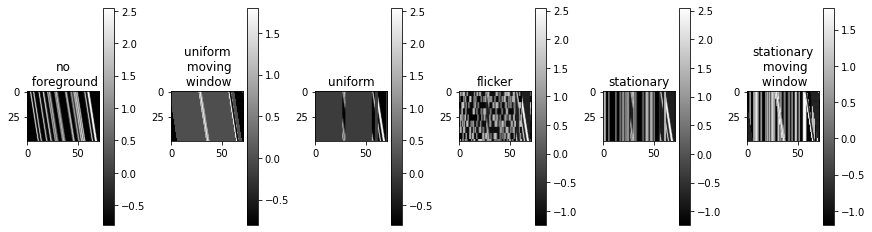

In [7]:
# check the synthetic stimuli
m = 0
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = GridSpec(1, 6, figure=fig)

ax = fig.add_subplot(gs[0, 0])
h = ax.imshow(stimuli_no_foreground_all[m].squeeze(), 'gray')
ax.set_title('no\n foreground')
plt.colorbar(h)

ax = fig.add_subplot(gs[0, 1])
h = ax.imshow(stimuli_uniform_moving_window_all[m].squeeze(), 'gray')
ax.set_title('uniform\n moving\n window')
plt.colorbar(h)

ax = fig.add_subplot(gs[0, 2])
h = ax.imshow(stimuli_uniform_all[m].squeeze(), 'gray')
ax.set_title('uniform')
plt.colorbar(h)

ax = fig.add_subplot(gs[0, 3])
h = ax.imshow(stimuli_structured_flicker_all[m].squeeze(), 'gray')
ax.set_title('flicker')
plt.colorbar(h)

ax = fig.add_subplot(gs[0, 4])
h = ax.imshow(stimuli_structured_all[m].squeeze(), 'gray')
ax.set_title('stationary')
plt.colorbar(h)

ax = fig.add_subplot(gs[0, 5])
h = ax.imshow(stimuli_structured_moving_window_all[m].squeeze(), 'gray')
ax.set_title('stationary\n moving\n window')
plt.colorbar(h)

plt.show()

# fig.savefig(figure_folder+f'synthetic_scene_motion.pdf', bbox_inches='tight')

In [8]:
# This is a slow cell
# Test models on the synthetic data
importlib.reload(models)
importlib.reload(hpfn)

pred_prob_no_foreground_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_prob_uniform_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_prob_structured_flicker_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_prob_structured_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_prob_uniform_moving_window_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_prob_structured_moving_window_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))

pred_logit_no_foreground_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_logit_uniform_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_logit_structured_flicker_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_logit_structured_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_logit_uniform_moving_window_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))
pred_logit_structured_moving_window_all = np.zeros((len(tick_label_list), k_folds*Repeat, M, Ts-30))

ind = 0
for k in k_list[0:1]:
    for D_cnn in D_cnn_list:
        for C in C_list:
            valid_loss_fold_list = []
            ind2 = 0
            for R in range(Repeat):
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_k{k}_' + config.activationf + f'_R{R+1}/'
                for fold in range(k_folds):
                    if os.path.exists(model_path + f'train_loss_fold_{fold+1}.pth'):
                        # load the model
                        network = models.CNNSpaceInv(D_cnn=D_cnn, C=C, k=k, 
                                                     od=config.od, activationf=config.activationf, T=config.T)
                        network.load_state_dict(torch.load(model_path + f'/model_fold_{fold+1}.pth'))
                        # test the model
#                         # no foreground
#                         pred_prob, pred_logit = hpfn.get_probability(network, stimuli_no_foreground_all)
#                         pred_prob_no_foreground_all[ind, ind2, :, :] = pred_prob
#                         pred_logit_no_foreground_all[ind, ind2, :, :] = pred_logit

#                         # uniform foreground
#                         pred_prob, pred_logit = hpfn.get_probability(network, stimuli_uniform_all)
#                         pred_prob_uniform_all[ind, ind2, :, :] = pred_prob
#                         pred_logit_uniform_all[ind, ind2, :, :] = pred_logit

#                         # flickering structured foreground
#                         pred_prob, pred_logit = hpfn.get_probability(network, stimuli_structured_flicker_all)
#                         pred_prob_structured_flicker_all[ind, ind2, :, :] = pred_prob
#                         pred_logit_structured_flicker_all[ind, ind2, :, :] = pred_logit

#                         # structured foreground
#                         pred_prob, pred_logit = hpfn.get_probability(network, stimuli_structured_all)
#                         pred_prob_structured_all[ind, ind2, :, :] = pred_prob
#                         pred_logit_structured_all[ind, ind2, :, :] = pred_logit
                        
                        # uniform foreground, moving window
                        pred_prob, pred_logit = hpfn.get_probability(network, stimuli_uniform_moving_window_all)
                        pred_prob_uniform_moving_window_all[ind, ind2, :, :] = pred_prob
                        pred_logit_uniform_moving_window_all[ind, ind2, :, :] = pred_logit
                        
#                         # structured foreground, moving window
#                         pred_prob, pred_logit = hpfn.get_probability(network, stimuli_structured_moving_window_all)
#                         pred_prob_structured_moving_window_all[ind, ind2, :, :] = pred_prob
#                         pred_logit_structured_moving_window_all[ind, ind2, :, :] = pred_logit
                        
                    ind2 = ind2 + 1
            ind = ind + 1


In [13]:
np.save(figure_folder + 'pred_prob_no_foreground_all', pred_prob_no_foreground_all)
np.save(figure_folder + 'pred_prob_uniform_all', pred_prob_uniform_all)
np.save(figure_folder + 'pred_prob_structured_flicker_all', pred_prob_structured_flicker_all)
np.save(figure_folder + 'pred_prob_structured_all', pred_prob_structured_all)
np.save(figure_folder + 'pred_prob_uniform_moving_window_all', pred_prob_uniform_moving_window_all)
np.save(figure_folder + 'pred_prob_structured_moving_window_all', pred_prob_structured_moving_window_all)

np.save(figure_folder + 'pred_logit_no_foreground_all', pred_logit_no_foreground_all)
np.save(figure_folder + 'pred_logit_uniform_all', pred_logit_uniform_all)
np.save(figure_folder + 'pred_logit_structured_flicker_all', pred_logit_structured_flicker_all)
np.save(figure_folder + 'pred_logit_structured_all', pred_logit_structured_all)
np.save(figure_folder + 'pred_logit_uniform_moving_window_all', pred_logit_uniform_moving_window_all)
np.save(figure_folder + 'pred_logit_structured_moving_window_all', pred_logit_structured_moving_window_all)


In [14]:
importlib.reload(models)
importlib.reload(hpfn)

auc_rocs = np.zeros((len(tick_label_list), k_folds*Repeat))
auc_rocs_heat = np.zeros((len(D_cnn_list), len(C_list), k_folds*Repeat))

ind = 0
for k in k_list[0:1]:
    for ind1, D_cnn in enumerate(D_cnn_list):
        for ind2, C in enumerate(C_list):
            ind3 = 0
            for R in range(Repeat):
                model_path = model_folder + f'Dcnn{D_cnn}_C{C}_k{k}_' + config.activationf + f'_R{R+1}/'
                for fold in range(k_folds):
                    if os.path.exists(model_path + f'train_loss_fold_{fold+1}.pth'):
                        # auc roc
                        target_path = model_path + f'y_test_all_fold_{fold+1}.pth'
                        prediction_path = model_path + f'y_pred_all_fold_{fold+1}.pth'    
                        target = torch.load(target_path)
                        prediction = torch.load(prediction_path)
                        prediction = np.array(prediction)
                        pred_prob, _ = hpfn.convert_logit_to_probability(prediction)
                        auc_roc = metrics.roc_auc_score(target, pred_prob)
                        auc_rocs[ind, ind3] = auc_roc
                        auc_rocs_heat[ind1, ind2, ind3] = auc_roc
                    ind3 = ind3 + 1
            ind = ind + 1

In [15]:
np.save(figure_folder + 'auc_rocs', auc_rocs)
np.save(figure_folder + 'auc_rocs_heat', auc_rocs_heat)


In [10]:
pred_prob_no_foreground_all = np.load(figure_folder + 'pred_prob_no_foreground_all.npy')
pred_prob_uniform_all = np.load(figure_folder + 'pred_prob_uniform_all.npy')
pred_prob_structured_flicker_all = np.load(figure_folder + 'pred_prob_structured_flicker_all.npy')
pred_prob_structured_all = np.load(figure_folder + 'pred_prob_structured_all.npy')
pred_prob_uniform_moving_window_all = np.load(figure_folder + 'pred_prob_uniform_moving_window_all.npy')
pred_prob_structured_moving_window_all = np.load(figure_folder + 'pred_prob_structured_moving_window_all.npy')

pred_logit_no_foreground_all = np.load(figure_folder + 'pred_logit_no_foreground_all.npy')
pred_logit_uniform_all = np.load(figure_folder + 'pred_logit_uniform_all.npy')
pred_logit_structured_flicker_all = np.load(figure_folder + 'pred_logit_structured_flicker_all.npy')
pred_logit_structured_all = np.load(figure_folder + 'pred_logit_structured_all.npy')
pred_logit_uniform_moving_window_all = np.load(figure_folder + 'pred_logit_uniform_moving_window_all.npy')
pred_logit_structured_moving_window_all = np.load(figure_folder + 'pred_logit_structured_moving_window_all.npy')

auc_rocs = np.load(figure_folder + 'auc_rocs.npy')
auc_rocs_heat = np.load(figure_folder + 'auc_rocs_heat.npy')


print(pred_prob_no_foreground_all.shape)
print(pred_logit_no_foreground_all.shape)


(48, 100, 100, 20)
(48, 100, 100, 20)


In [11]:
pred_logprob_no_foreground_all = np.log(pred_prob_no_foreground_all+1e-10)
pred_logprob_uniform_all = np.log(pred_prob_uniform_all+1e-10)
pred_logprob_structured_flicker_all = np.log(pred_prob_structured_flicker_all+1e-10)
pred_logprob_structured_all = np.log(pred_prob_structured_all+1e-10)
pred_logprob_structured_moving_window_all = np.log(pred_prob_structured_moving_window_all+1e-10)



In [12]:
# To calculate the rank order correlations, for each realization of each model, 
# I calculated the mean of the responses from all 100 responses.
# To calculate the ratio, for each model, I calculated the mean of all the responses from
# all 100 responses for all realizations.

pred_prob_no_foreground_mean2 = pred_prob_no_foreground_all.mean(axis=(2, 3))
pred_prob_uniform_mean2 = pred_prob_uniform_all.mean(axis=(2, 3))
pred_prob_structured_flicker_mean2 = pred_prob_structured_flicker_all.mean(axis=(2, 3))
pred_prob_structured_mean2 = pred_prob_structured_all.mean(axis=(2, 3))

pred_logit_no_foreground_mean2 = pred_logit_no_foreground_all.mean(axis=(2, 3))
pred_logit_uniform_mean2 = pred_logit_uniform_all.mean(axis=(2, 3))
pred_logit_structured_flicker_mean2 = pred_logit_structured_flicker_all.mean(axis=(2, 3))
pred_logit_structured_mean2 = pred_logit_structured_all.mean(axis=(2, 3))

Dcnn_C_fold = np.zeros((len(D_cnn_list), len(C_list), k_folds*Repeat, 4))
stat_unif_prob_ratio = np.zeros((len(D_cnn_list), len(C_list)))
stat_unif_logit_diff = np.zeros((len(D_cnn_list), len(C_list)))
flck_unif_logit_diff = np.zeros((len(D_cnn_list), len(C_list)))
unif_nofg_logit_diff = np.zeros((len(D_cnn_list), len(C_list)))
ind = 0
for ind1, D_cnn in enumerate(D_cnn_list):
    for ind2, C in enumerate(C_list):
        Dcnn_C_fold[ind1, ind2, :, 0] = pred_logit_no_foreground_mean2[ind]
        Dcnn_C_fold[ind1, ind2, :, 1] = pred_logit_uniform_mean2[ind]
        Dcnn_C_fold[ind1, ind2, :, 2] = pred_logit_structured_flicker_mean2[ind]
        Dcnn_C_fold[ind1, ind2, :, 3] = pred_logit_structured_mean2[ind]
        stat_unif_prob_ratio[ind1, ind2] = pred_prob_structured_mean2.mean(axis=(-1))[ind] / pred_prob_uniform_mean2.mean(axis=(-1))[ind]
        stat_unif_logit_diff[ind1, ind2] = pred_logit_uniform_mean2.mean(axis=(-1))[ind] - pred_logit_structured_mean2.mean(axis=(-1))[ind]
        flck_unif_logit_diff[ind1, ind2] = pred_logit_uniform_mean2.mean(axis=(-1))[ind] - pred_logit_structured_flicker_mean2.mean(axis=(-1))[ind] 
        unif_nofg_logit_diff[ind1, ind2] = pred_logit_no_foreground_mean2.mean(axis=(-1))[ind] - pred_logit_uniform_mean2.mean(axis=(-1))[ind] 
        ind = ind + 1
            
        

In [13]:
Dcnn_C_corr = -np.ones((len(D_cnn_list), len(C_list), k_folds*Repeat))
for k in k_list[0:1]:
    for ind1, D_cnn in enumerate(D_cnn_list):
        for ind2, C in enumerate(C_list):
            for fold in range(k_folds*Repeat):
                if Dcnn_C_fold[ind1, ind2, fold].any():
                    Dcnn_C_corr[ind1, ind2, fold] = hpfn.get_rank_order_corr(np.flip(np.argsort(Dcnn_C_fold[ind1, ind2, fold])), np.arange(4))
                    Dcnn_C_corr[ind1, ind2, fold] = hpfn.get_rank_order_corr(np.flip(np.argsort(Dcnn_C_fold[ind1, ind2, fold])), np.arange(4))
                    Dcnn_C_corr[ind1, ind2, fold] = hpfn.get_rank_order_corr(np.flip(np.argsort(Dcnn_C_fold[ind1, ind2, fold])), np.arange(4))
                    Dcnn_C_corr[ind1, ind2, fold] = hpfn.get_rank_order_corr(np.flip(np.argsort(Dcnn_C_fold[ind1, ind2, fold])), np.arange(4))
        
        

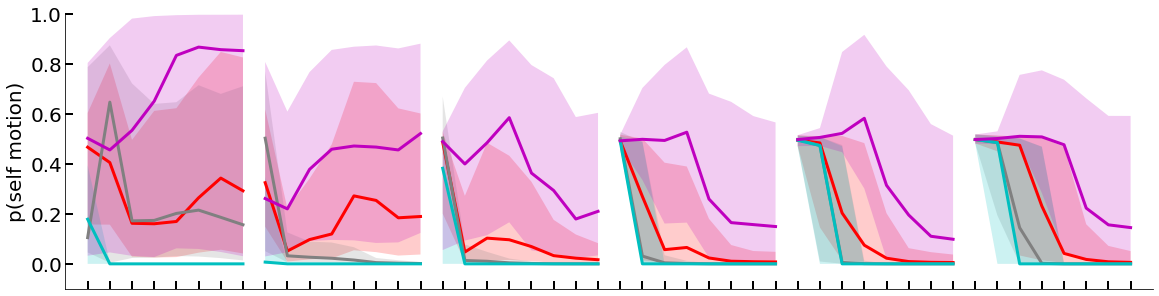

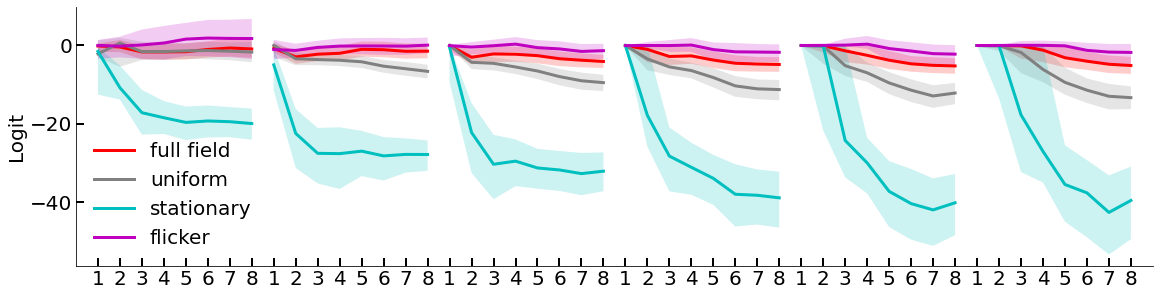

In [14]:
font_size = 20
label_size = 20
line_width = 3
marker_size = 6
legend_list = ['full field', 'uniform', 'stationary', 'flicker']
M = 100 # number of sample stimuli
Repeat = config.Repeat
k_folds = config.k_folds

auc_rocs_mean = auc_rocs.mean(axis=1)
indices = np.argsort(auc_rocs_mean)
tick_label_list_reordered = []
for ind in indices:
    tick_label_list_reordered.append(tick_label_list[ind])
x = list(range(len(indices)))
tick_label_list_number = [1, 2, 3, 4, 5, 6, 7, 8] * 6


# median
pred_prob_no_foreground_median = np.median(pred_prob_no_foreground_all, axis=(1, 2, 3))
pred_prob_uniform_median = np.median(pred_prob_uniform_all, axis=(1, 2, 3))
pred_prob_structured_median = np.median(pred_prob_structured_all, axis=(1, 2, 3))
pred_prob_structured_flicker_median = np.median(pred_prob_structured_flicker_all, axis=(1, 2, 3))

# 25th quantile
pred_prob_no_foreground_25thQ = np.quantile(pred_prob_no_foreground_all, q=0.25, axis=(1, 2, 3))
pred_prob_uniform_25thQ = np.quantile(pred_prob_uniform_all, q=0.25, axis=(1, 2, 3))
pred_prob_structured_25thQ = np.quantile(pred_prob_structured_all, q=0.25, axis=(1, 2, 3))
pred_prob_structured_flicker_25thQ = np.quantile(pred_prob_structured_flicker_all, q=0.25, axis=(1, 2, 3))

# 75th quantile
pred_prob_no_foreground_75thQ = np.quantile(pred_prob_no_foreground_all, q=0.75, axis=(1, 2, 3))
pred_prob_uniform_75thQ = np.quantile(pred_prob_uniform_all, q=0.75, axis=(1, 2, 3))
pred_prob_structured_75thQ = np.quantile(pred_prob_structured_all, q=0.75, axis=(1, 2, 3))
pred_prob_structured_flicker_75thQ = np.quantile(pred_prob_structured_flicker_all, q=0.75, axis=(1, 2, 3))

fig = plt.figure(figsize=(16, 4), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
for ii in range(6):
    ax.fill_between(x[ii*8:(ii+1)*8], pred_prob_no_foreground_75thQ[ii*8:(ii+1)*8], pred_prob_no_foreground_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='r', alpha=0.2)
    ax.fill_between(x[ii*8:(ii+1)*8], pred_prob_uniform_75thQ[ii*8:(ii+1)*8], pred_prob_uniform_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='grey', alpha=0.2)
    ax.fill_between(x[ii*8:(ii+1)*8], pred_prob_structured_75thQ[ii*8:(ii+1)*8], pred_prob_structured_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='c', alpha=0.2)
    ax.fill_between(x[ii*8:(ii+1)*8], pred_prob_structured_flicker_75thQ[ii*8:(ii+1)*8], pred_prob_structured_flicker_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='m', alpha=0.2)

    ax.plot(x[ii*8:(ii+1)*8], pred_prob_no_foreground_median[ii*8:(ii+1)*8], '-', c='r', linewidth=line_width, markersize=marker_size)
    ax.plot(x[ii*8:(ii+1)*8], pred_prob_uniform_median[ii*8:(ii+1)*8], '-', c='grey', linewidth=line_width, markersize=marker_size)
    ax.plot(x[ii*8:(ii+1)*8], pred_prob_structured_median[ii*8:(ii+1)*8], '-', c='c', linewidth=line_width, markersize=marker_size)
    ax.plot(x[ii*8:(ii+1)*8], pred_prob_structured_flicker_median[ii*8:(ii+1)*8], '-', c='m', linewidth=line_width, markersize=marker_size)
    
ax.set_xlim([-1, 48])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_ylim([-0.1, 1])
ax.set_xticks(x)
ax.set_xticklabels([])
ax.set_ylabel('p(self motion)', fontsize=font_size)
ax.tick_params(direction='in', length=8, width=2, labelsize=label_size)

fig.savefig(figure_folder + 'figure_for_paper_line_plot1_median.pdf', bbox_inches='tight')

plt.show()


####### Logits

# median
pred_logit_no_foreground_median = np.median(pred_logit_no_foreground_all, axis=(1, 2, 3))
pred_logit_uniform_median = np.median(pred_logit_uniform_all, axis=(1, 2, 3))
pred_logit_structured_median = np.median(pred_logit_structured_all, axis=(1, 2, 3))
pred_logit_structured_flicker_median = np.median(pred_logit_structured_flicker_all, axis=(1, 2, 3))

# 25th quantile
pred_logit_no_foreground_25thQ = np.quantile(pred_logit_no_foreground_all, q=0.25, axis=(1, 2, 3))
pred_logit_uniform_25thQ = np.quantile(pred_logit_uniform_all, q=0.25, axis=(1, 2, 3))
pred_logit_structured_25thQ = np.quantile(pred_logit_structured_all, q=0.25, axis=(1, 2, 3))
pred_logit_structured_flicker_25thQ = np.quantile(pred_logit_structured_flicker_all, q=0.25, axis=(1, 2, 3))

# 75th quantile
pred_logit_no_foreground_75thQ = np.quantile(pred_logit_no_foreground_all, q=0.75, axis=(1, 2, 3))
pred_logit_uniform_75thQ = np.quantile(pred_logit_uniform_all, q=0.75, axis=(1, 2, 3))
pred_logit_structured_75thQ = np.quantile(pred_logit_structured_all, q=0.75, axis=(1, 2, 3))
pred_logit_structured_flicker_75thQ = np.quantile(pred_logit_structured_flicker_all, q=0.75, axis=(1, 2, 3))

fig = plt.figure(figsize=(16, 4), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
for ii in range(6):
    ax.fill_between(x[ii*8:(ii+1)*8], pred_logit_no_foreground_75thQ[ii*8:(ii+1)*8], pred_logit_no_foreground_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='r', alpha=0.2)
    ax.fill_between(x[ii*8:(ii+1)*8], pred_logit_uniform_75thQ[ii*8:(ii+1)*8], pred_logit_uniform_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='grey', alpha=0.2)
    ax.fill_between(x[ii*8:(ii+1)*8], pred_logit_structured_75thQ[ii*8:(ii+1)*8], pred_logit_structured_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='c', alpha=0.2)
    ax.fill_between(x[ii*8:(ii+1)*8], pred_logit_structured_flicker_75thQ[ii*8:(ii+1)*8], pred_logit_structured_flicker_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='m', alpha=0.2)

    ax.plot(x[ii*8:(ii+1)*8], pred_logit_no_foreground_median[ii*8:(ii+1)*8], '-', c='r', linewidth=line_width, markersize=marker_size)
    ax.plot(x[ii*8:(ii+1)*8], pred_logit_uniform_median[ii*8:(ii+1)*8], '-', c='grey', linewidth=line_width, markersize=marker_size)
    ax.plot(x[ii*8:(ii+1)*8], pred_logit_structured_median[ii*8:(ii+1)*8], '-', c='c', linewidth=line_width, markersize=marker_size)
    ax.plot(x[ii*8:(ii+1)*8], pred_logit_structured_flicker_median[ii*8:(ii+1)*8], '-', c='m', linewidth=line_width, markersize=marker_size)
    
ax.set_xlim([-1, 48])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xticks(x)
# ax.set_xticklabels(tick_label_list, rotation=90)
ax.set_xticklabels(tick_label_list_number, verticalalignment='top')
ax.set_ylabel('Logit', fontsize=font_size)
ax.tick_params(direction='in', length=8, width=2, labelsize=label_size)
ax.legend(legend_list, prop={'size': label_size}, frameon=False)

fig.savefig(figure_folder + 'figure_for_paper_line_plot2_median.pdf', bbox_inches='tight')

plt.show()



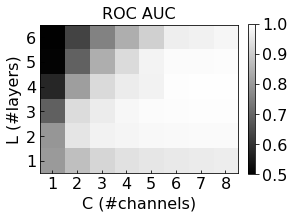

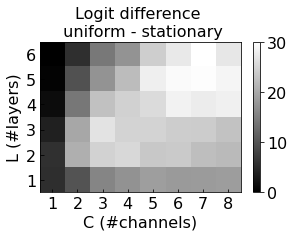

In [13]:
font_size = 16
label_size = 16
line_width = 3
marker_size = 6
M = 100 # number of sample stimuli
Repeat = config.Repeat
k_folds = config.k_folds

auc_rocs_mean = auc_rocs.mean(axis=1)
indices = np.argsort(auc_rocs_mean)
tick_label_list_reordered = []
for ind in indices:
    tick_label_list_reordered.append(tick_label_list[ind])
x = list(range(len(indices)))

fig = plt.figure(figsize=(4, 3), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(auc_rocs_heat.mean(axis=-1), 'gray', vmin=0.5, vmax=1)
ax.invert_yaxis()
ax.set_xticks(list(range(len(C_list))))
ax.set_xticklabels(list(range(1, len(C_list)+1)))
ax.set_yticks(list(range(len(D_cnn_list))))
ax.set_yticklabels(list(range(1, len(D_cnn_list)+1)))
ax.set_xlabel('C (#channels)', fontsize=font_size)
ax.set_ylabel('L (#layers)', fontsize=font_size)
ax.tick_params(direction='in', labelsize=label_size)
ax.set_title('ROC AUC', fontsize=font_size)
cbar = plt.colorbar(im, fraction=0.038, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar.ax.tick_params(labelsize=label_size)

fig.savefig(figure_folder + 'figure_for_paper_heatmap1.pdf', bbox_inches='tight')

plt.show()


fig = plt.figure(figsize=(4*1.07, 3*1.07), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(stat_unif_logit_diff, 'gray', vmin=0, vmax=30)
# im = ax.imshow(1-stat_unif_prob_ratio, 'gray')
ax.invert_yaxis()
ax.set_xticks(list(range(len(C_list))))
ax.set_xticklabels(list(range(1, len(C_list)+1)))
ax.set_yticks(list(range(len(D_cnn_list))))
ax.set_yticklabels(list(range(1, len(D_cnn_list)+1)))
ax.set_xlabel('C (#channels)', fontsize=font_size)
ax.set_ylabel('L (#layers)', fontsize=font_size)
ax.tick_params(direction='in', labelsize=label_size)
ax.set_title('Logit difference \n uniform - stationary', fontsize=font_size)
cbar = plt.colorbar(im, fraction=0.038, ticks=[0, 10, 20, 30])
cbar.ax.tick_params(labelsize=label_size)

fig.savefig(figure_folder + 'figure_for_paper_heatmap2.pdf', bbox_inches='tight')

plt.show()



# Check the parameters of the trained models

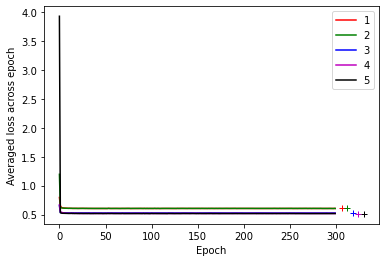

0.7529107850712173
0.743629687919914
0.8349788548105348
0.8689046534869658
0.8676329212577265


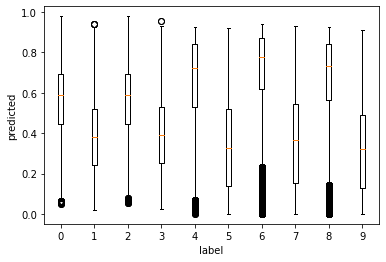

In [14]:
R = 0
k = 3
D_cnn = 1
C = 1
model_path = model_folder + f'Dcnn{D_cnn}_C{C}_k{k}_' + config.activationf + f'_R{R+1}/'

# Loss functions
color_fold = ['r', 'g', 'b', 'm', 'k']
legend_list = []
fig = plt.figure()
for fold in range(5):
    loss_path = model_path + f'train_loss_fold_{fold+1}.pth'
    loss = torch.load(loss_path)
    lines = plt.plot(loss, c=color_fold[fold])
    valid_loss = torch.load(model_path + f'valid_loss_fold_{fold+1}_final.pth')
    plt.plot(len(loss)*(1.+0.02*(fold+1)), valid_loss, '+', c=color_fold[fold])
    legend_list.append(lines[0])
plt.xlabel('Epoch')
plt.ylabel('Averaged loss across epoch')
plt.legend(legend_list, [1, 2, 3, 4, 5])
plt.show()

fig.savefig(figure_folder+'loss_cnn.pdf', bbox_inches='tight')


# Loss functions
color_fold = ['r', 'g', 'b', 'm', 'k']
legend_list = []
fig = plt.figure()
for fold in range(5):
    y_pred_path = model_path + f'y_pred_all_fold_{fold+1}.pth'
    y_pred_all = np.array(torch.load(y_pred_path))
    logit_all = y_pred_all[:, 1] - y_pred_all[:, 0]
    pred_prob = hpfn.get_sigmoid(1, 0, logit_all)
    y_test_path = model_path + f'y_test_all_fold_{fold+1}.pth'
    y_test_all = np.array(torch.load(y_test_path))
    auc_roc = metrics.roc_auc_score(y_test_all, pred_prob)
    print(auc_roc)
    
    pred_prob_1 = pred_prob[y_test_all==1]
    pred_prob_0 = pred_prob[y_test_all==0]
    plt.boxplot(pred_prob_1, positions=[0+fold*2])
    plt.boxplot(pred_prob_0, positions=[1+fold*2])
    legend_list.append(lines[0])
plt.xlabel('label')
plt.ylabel('predicted')
plt.show()

fig.savefig(figure_folder+'ypred_vs_ytest.pdf', bbox_inches='tight')

In [15]:
importlib.reload(models)

# Print the model configurations
fold = 5
network = models.CNNSpaceInv(D_cnn=D_cnn, C=C, k=k, od=2)
network.load_state_dict(torch.load(model_path + f'/model_fold_{fold}.pth'))
network.eval()

CNNSpaceInv(
  (cnn_layers): ModuleList(
    (0): Conv2d(30, 1, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), padding_mode=circular)
  )
  (output_layer): Conv2d(1, 2, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
)

In [16]:
# Print all the parameters
for name, param in network.named_parameters():
    print(name, param.data.size())
    if name != 'cnn_layers.0.weight':
        print(param.data.numpy().squeeze())
    

cnn_layers.0.weight torch.Size([1, 30, 1, 3])
cnn_layers.0.bias torch.Size([1])
-0.4685939
output_layer.weight torch.Size([2, 1, 1, 1])
[ 0.2166509  -0.21657263]
output_layer.bias torch.Size([2])
[-0.17572315 -0.14114197]


In [17]:
# Print all the parameters
for name, param in network.named_parameters():
    print(name, param.data.size())
    if name == 'output_layer.weight':
        print(param.data.numpy().squeeze()[0])
        print(param.data.numpy().squeeze()[1])
        

cnn_layers.0.weight torch.Size([1, 30, 1, 3])
cnn_layers.0.bias torch.Size([1])
output_layer.weight torch.Size([2, 1, 1, 1])
0.2166509
-0.21657263
output_layer.bias torch.Size([2])


In [18]:
# Extract parameters
for name, param in network.named_parameters():
    if param.requires_grad and name == 'cnn_layers.0.weight':
        print(param.data.size())
        cnn_layer_0_weight = param.data.numpy()
    if param.requires_grad and name == 'output_layer.weight':
        print(param.data.size())
        output_layer_weight = param.data.numpy().squeeze()
    
    

torch.Size([1, 30, 1, 3])
torch.Size([2, 1, 1, 1])


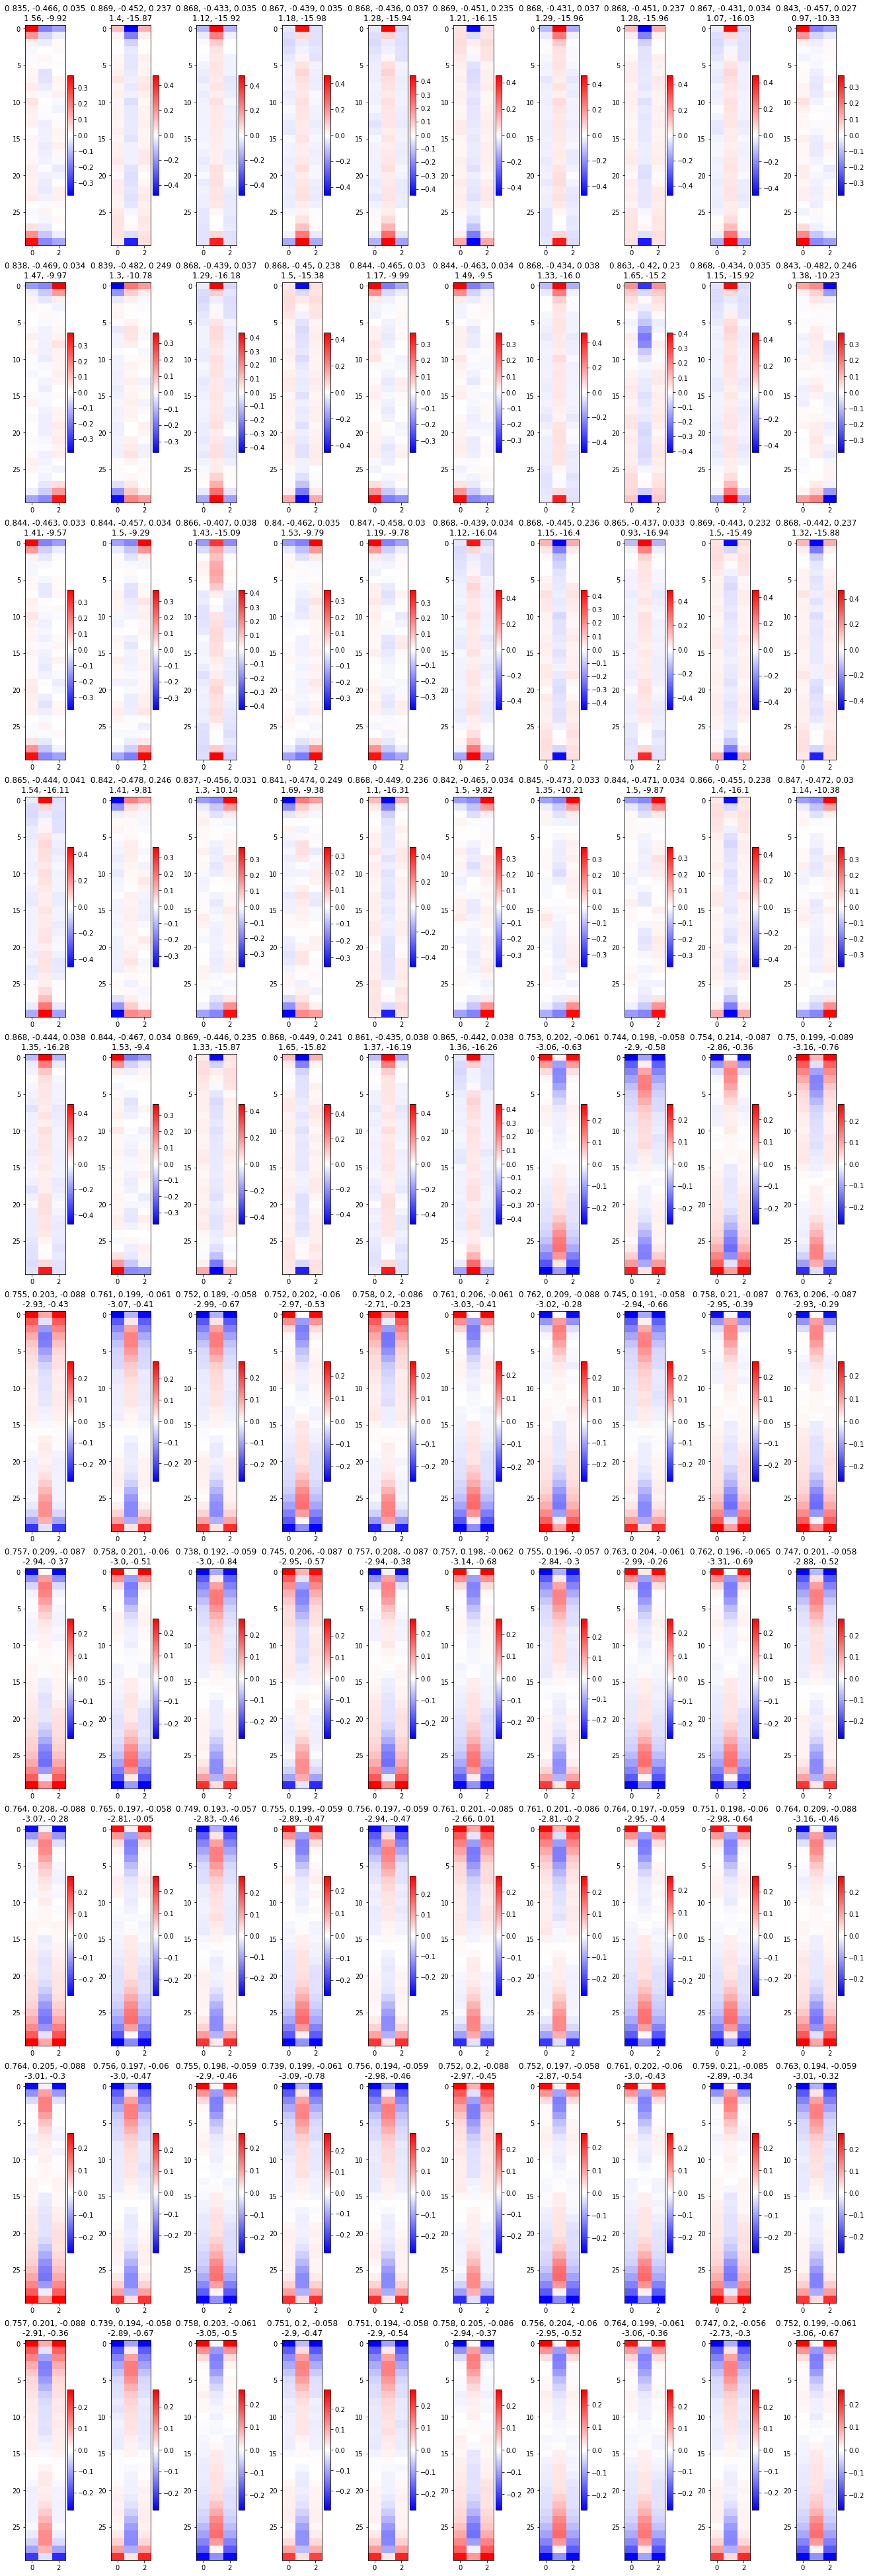

In [19]:
# Check the temporal filters

k = 3
D_cnn = 1
C = 1
color_fold = ['r', 'g', 'b', 'm', 'k']
colormap_filter = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256, gamma=1)

fig = plt.figure(figsize=(18, 54), constrained_layout=True)
gs = GridSpec(10, 10, figure=fig)

ind = 0
count_spatial_diff = 0
count_temporal_diff = 0
auc_spatial_diff = []
auc_temporal_diff = []
logit_diff_spatial_diff = []
logit_diff_temporal_diff = []
for R in range(20):
    model_path = model_folder + f'Dcnn{D_cnn}_C{C}_k{k}_' + config.activationf + f'_R{R+1}/'
    network = models.CNNSpaceInv(D_cnn=D_cnn, C=C, k=k, od=2)
    for fold in range(5):
        y_pred_path = model_path + f'y_pred_all_fold_{fold+1}.pth'
        y_pred_all = np.array(torch.load(y_pred_path))
        logit_all = y_pred_all[:, 1] - y_pred_all[:, 0]
        pred_prob = hpfn.get_sigmoid(1, 0, logit_all)
        y_test_path = model_path + f'y_test_all_fold_{fold+1}.pth'
        y_test_all = np.array(torch.load(y_test_path))
        auc_roc = metrics.roc_auc_score(y_test_all, pred_prob)
        
        # Extract parameters
        network.load_state_dict(torch.load(model_path + f'model_fold_{fold+1}.pth'))
        for name, param in network.named_parameters():
            if param.requires_grad and name == 'cnn_layers.0.weight':
                cnn_layer_0_weight = param.data.numpy()
            if param.requires_grad and name == 'output_layer.weight':
                output_layer_weight = param.data.numpy().squeeze()
            if param.requires_grad and name == 'output_layer.bias':
                output_layer_bias = param.data.numpy().squeeze()
            
        if np.sign(cnn_layer_0_weight[0][0, 0, 0]) * np.sign(cnn_layer_0_weight[0][-1, 0, 0]) > 0:
            rown = int(count_spatial_diff / 10)
            coln = count_spatial_diff % 10
            ax = fig.add_subplot(gs[rown, coln])
            v_max = np.abs(cnn_layer_0_weight).max()
            for jj in range(1):
                im = ax.imshow(cnn_layer_0_weight[0][::-1, jj, :], cmap=colormap_filter, aspect='auto', vmin=-v_max, vmax=v_max)
                plt.colorbar(im)
            ax.set_title(f'{str(np.round(auc_roc, 3))}, {str(np.round(output_layer_weight[1]-output_layer_weight[0], 3))}, {str(np.round(output_layer_bias[1]-output_layer_bias[0], 3))}\n'
                        + f'{str(np.round(pred_logit_uniform_all[0][ind].mean(), 2))}, {str(np.round(pred_logit_structured_all[0][ind].mean(), 2))}')
            
            count_spatial_diff = count_spatial_diff + 1
            auc_spatial_diff.append(auc_roc)
            logit_diff_spatial_diff.append(output_layer_weight[1]-output_layer_weight[0])
        else:
            rown = int((count_temporal_diff + 46) / 10)
            coln = (count_temporal_diff + 46) % 10
            ax = fig.add_subplot(gs[rown, coln])
            v_max = np.abs(cnn_layer_0_weight).max()
            for jj in range(1):
                im = ax.imshow(cnn_layer_0_weight[0][::-1, jj, :], cmap=colormap_filter, aspect='auto', vmin=-v_max, vmax=v_max)
                plt.colorbar(im)
            ax.set_title(f'{str(np.round(auc_roc, 3))}, {str(np.round(output_layer_weight[1]-output_layer_weight[0], 3))}, {str(np.round(output_layer_bias[1]-output_layer_bias[0], 3))}\n'
                        + f'{str(np.round(pred_logit_uniform_all[0][ind].mean(), 2))}, {str(np.round(pred_logit_structured_all[0][ind].mean(), 2))}')
            
            count_temporal_diff = count_temporal_diff + 1
            auc_temporal_diff.append(auc_roc)
            logit_diff_temporal_diff.append(output_layer_weight[1]-output_layer_weight[0])
            
        ind = ind + 1

plt.show()
fig.savefig(figure_folder + f'Dcnn{D_cnn}_C{C}_k{k}_' + config.activationf + '.pdf', bbox_inches='tight')



In [20]:
print(count_spatial_diff, count_temporal_diff)


46 54


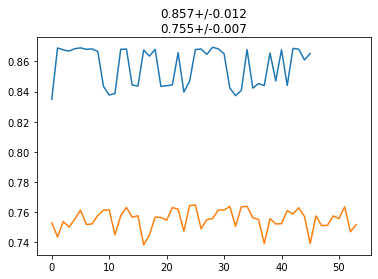

In [21]:
plt.plot(auc_spatial_diff)
plt.plot(auc_temporal_diff)
plt.title(f'{np.round(np.mean(auc_spatial_diff), 3)}+/-{np.round(np.std(auc_spatial_diff), 3)}\n' + 
         f'{np.round(np.mean(auc_temporal_diff), 3)}+/-{np.round(np.std(auc_temporal_diff), 3)}')
plt.show()

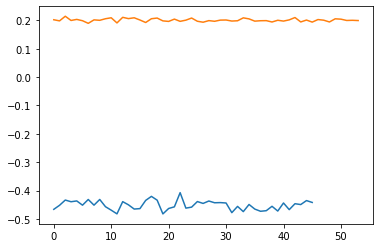

In [22]:
plt.plot(logit_diff_spatial_diff)
plt.plot(logit_diff_temporal_diff)
plt.show()

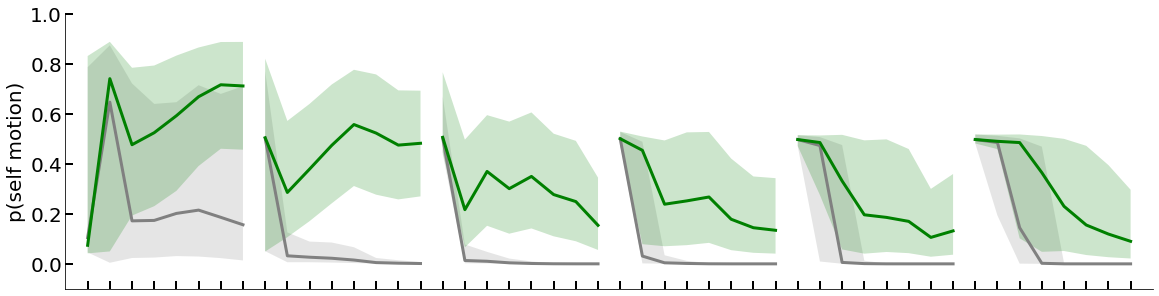

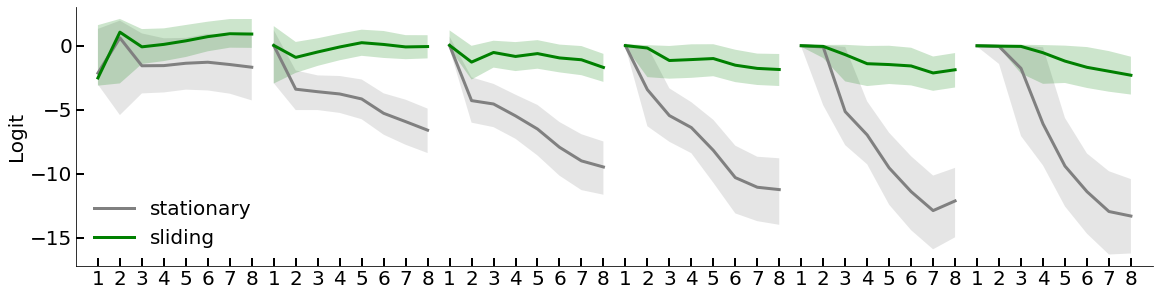

In [18]:
font_size = 20
label_size = 20
line_width = 3
marker_size = 6
legend_list = ['stationary', 'sliding']
M = 100 # number of sample stimuli
Repeat = config.Repeat
k_folds = config.k_folds

auc_rocs_mean = auc_rocs.mean(axis=1)
indices = np.argsort(auc_rocs_mean)
tick_label_list_reordered = []
for ind in indices:
    tick_label_list_reordered.append(tick_label_list[ind])
x = list(range(len(indices)))
tick_label_list_number = [1, 2, 3, 4, 5, 6, 7, 8] * 6


# median
pred_prob_uniform_median = np.median(pred_prob_uniform_all, axis=(1, 2, 3))
pred_prob_uniform_moving_window_median = np.median(pred_prob_uniform_moving_window_all, axis=(1, 2, 3))

# 25th quantile
pred_prob_uniform_25thQ = np.quantile(pred_prob_uniform_all, q=0.25, axis=(1, 2, 3))
pred_prob_uniform_moving_window_25thQ = np.quantile(pred_prob_uniform_moving_window_all, q=0.25, axis=(1, 2, 3))

# 75th quantile
pred_prob_uniform_75thQ = np.quantile(pred_prob_uniform_all, q=0.75, axis=(1, 2, 3))
pred_prob_uniform_moving_window_75thQ = np.quantile(pred_prob_uniform_moving_window_all, q=0.75, axis=(1, 2, 3))

fig = plt.figure(figsize=(16, 4), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
for ii in range(6):
    ax.fill_between(x[ii*8:(ii+1)*8], pred_prob_uniform_75thQ[ii*8:(ii+1)*8], pred_prob_uniform_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='grey', alpha=0.2)
    ax.fill_between(x[ii*8:(ii+1)*8], pred_prob_uniform_moving_window_75thQ[ii*8:(ii+1)*8], pred_prob_uniform_moving_window_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='g', alpha=0.2)

    ax.plot(x[ii*8:(ii+1)*8], pred_prob_uniform_median[ii*8:(ii+1)*8], '-', c='grey', linewidth=line_width, markersize=marker_size)
    ax.plot(x[ii*8:(ii+1)*8], pred_prob_uniform_moving_window_median[ii*8:(ii+1)*8], '-', c='g', linewidth=line_width, markersize=marker_size)
    
ax.set_xlim([-1, 48])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_ylim([-0.1, 1])
ax.set_xticks(x)
ax.set_xticklabels([])
ax.set_ylabel('p(self motion)', fontsize=font_size)
ax.tick_params(direction='in', length=8, width=2, labelsize=label_size)

fig.savefig(figure_folder + 'figure_for_paper_line_plot1_median_supp.pdf', bbox_inches='tight')

plt.show()


####### Logits

# median
pred_logit_uniform_median = np.median(pred_logit_uniform_all, axis=(1, 2, 3))
pred_logit_uniform_moving_window_median = np.median(pred_logit_uniform_moving_window_all, axis=(1, 2, 3))

# 25th quantile
pred_logit_uniform_25thQ = np.quantile(pred_logit_uniform_all, q=0.25, axis=(1, 2, 3))
pred_logit_uniform_moving_window_25thQ = np.quantile(pred_logit_uniform_moving_window_all, q=0.25, axis=(1, 2, 3))

# 75th quantile
pred_logit_uniform_75thQ = np.quantile(pred_logit_uniform_all, q=0.75, axis=(1, 2, 3))
pred_logit_uniform_moving_window_75thQ = np.quantile(pred_logit_uniform_moving_window_all, q=0.75, axis=(1, 2, 3))

fig = plt.figure(figsize=(16, 4), constrained_layout=True)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])
for ii in range(6):
    ax.fill_between(x[ii*8:(ii+1)*8], pred_logit_uniform_75thQ[ii*8:(ii+1)*8], pred_logit_uniform_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='grey', alpha=0.2)
    ax.fill_between(x[ii*8:(ii+1)*8], pred_logit_uniform_moving_window_75thQ[ii*8:(ii+1)*8], pred_logit_uniform_moving_window_25thQ[ii*8:(ii+1)*8], edgecolor='none', facecolor='g', alpha=0.2)

    ax.plot(x[ii*8:(ii+1)*8], pred_logit_uniform_median[ii*8:(ii+1)*8], '-', c='grey', linewidth=line_width, markersize=marker_size)
    ax.plot(x[ii*8:(ii+1)*8], pred_logit_uniform_moving_window_median[ii*8:(ii+1)*8], '-', c='g', linewidth=line_width, markersize=marker_size)
    
ax.set_xlim([-1, 48])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xticks(x)
# ax.set_xticklabels(tick_label_list, rotation=90)
ax.set_xticklabels(tick_label_list_number, verticalalignment='top')
ax.set_ylabel('Logit', fontsize=font_size)
ax.tick_params(direction='in', length=8, width=2, labelsize=label_size)
ax.legend(legend_list, prop={'size': label_size}, frameon=False)

fig.savefig(figure_folder + 'figure_for_paper_line_plot2_median_supp.pdf', bbox_inches='tight')

plt.show()